In [1]:
import networkx as nx
import torch
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import math 
import matplotlib.pyplot as plt

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

av = Namespace( want_cuda                    = True,
                  has_cuda                   = torch.cuda.is_available(),
                  BATCH_SIZE                 = 128,
                  RANDOM_STATE               = 42,
                  DATASET_NAME               = "Mutagenicity",
                  filters_1                  = 64,
                  filters_2                  = 64,
                  filters_3                  = 64,
                  DROPOUT                    = 0.5, 
                  CONV                       = "Graph",
                  LEARNING_RATE              = 0.0001,
                  FEAT_MASK_SZ_COEFF         = 0.1,
                  EDGE_MASK_SZ_COEFF         = 0.3,
                  FEAT_MASK_ENT_COEFF        = 0.1,
                  EDGE_MASK_ENT_COEFF        = 0.1,
                  DIR_PATH                   =".")


In [2]:
from src.dataset import GraphDataset
from src.gnn import GNNmodel
from src.utils import evaluate_accuracy,cudavar,train,train_explainer,cudavar
from src.explainer import GNNexplainer
gdata = GraphDataset(av)
gdata.dataset.num_classes

Datasets/Mutagenicity_689_data1.pkl


/mnt/infonas/data/indraroy15/new_bee_venv/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


2

In [3]:
model = GNNmodel(av, gdata.dataset.num_node_features,\
                 gdata.dataset.num_classes).cuda()


In [4]:
train(av,gdata.loader_train,gdata.loader_valid,model)

In [5]:
fp = av.DIR_PATH+"/best_val_models/"+av.DATASET_NAME+\
                       '_'+ av.CONV+'_'+str(av.LEARNING_RATE)
checkpoint=torch.load(fp)
m1 = GNNmodel(av, gdata.dataset.num_node_features,\
                 gdata.dataset.num_classes).cuda()
m1.load_state_dict(checkpoint)
evaluate_accuracy(m1, gdata.loader_test)


0.8006912442396313

In [4]:
from torch_geometric.data import Data, Batch
test_data = next(iter(gdata.loader_test))[0]
# print(test_data)
test_data_batch = Batch.from_data_list([test_data]).cuda()
# print(test_data)

In [5]:
model_exp = GNNexplainer(av,model,test_data_batch.x.shape[0],\
                         test_data_batch.x.shape[1],\
                         test_data_batch.edge_index.shape[1]).cuda()

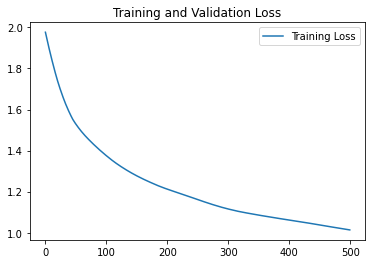

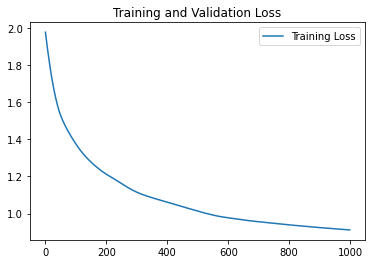

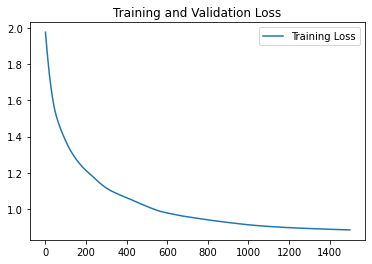

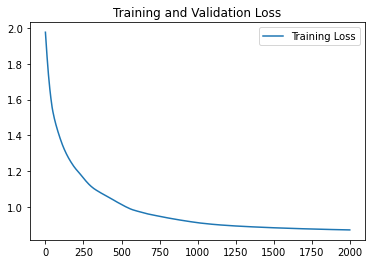

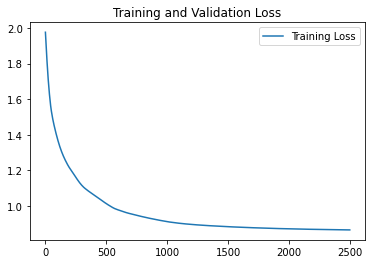

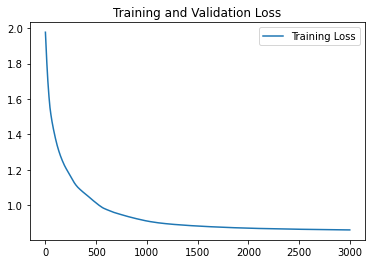

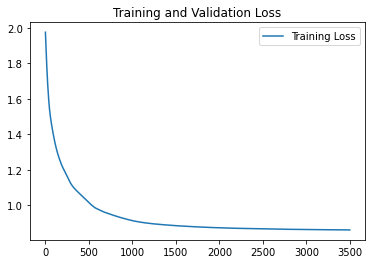

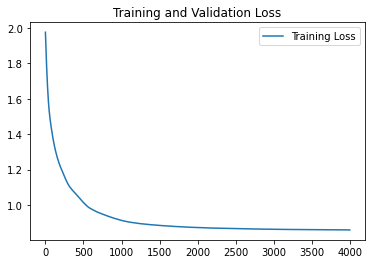

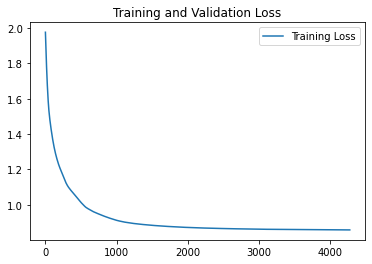

In [6]:
node_feat_mask, edge_mask = train_explainer(av, model_exp, test_data_batch)

In [7]:
torch.round(edge_mask),\
torch.sum(torch.round(edge_mask)).item(), len(edge_mask)

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
        device='cuda:0'),
 23.0,
 54)

In [9]:
torch.round(node_feat_mask),\
torch.sum(torch.round(node_feat_mask)).item(), len(node_feat_mask)

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1.0, 14)

In [10]:
rounded_edge_mask = torch.round(edge_mask)
dict_edge_mask= {}
for (s,(n1,n2)) in (zip(rounded_edge_mask.tolist(), test_data.edge_index.T.tolist())): 
    if n1>n2:
        n1,n2 = n2,n1
    #same edge can appear twice for directed graphs. We average 
    if (n1,n2) in dict_edge_mask: 
        dict_edge_mask[(n1,n2)] = (dict_edge_mask[(n1,n2)] + s)/2
    else: 
        dict_edge_mask[(n1,n2)] = s

In [11]:
G = pyg_utils.to_networkx(test_data,to_undirected=True)

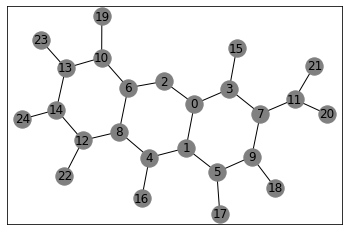

In [18]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=pos,node_color="grey")

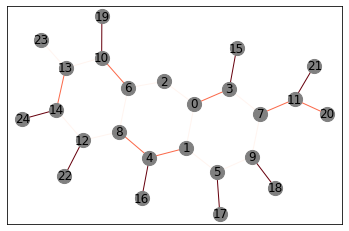

In [17]:
edge_color = [dict_edge_mask[(u, v)] for u, v in edgelist]
nx.draw_networkx(
        G, pos=pos,
        node_size=200,
        edge_color=edge_color, 
        edge_cmap=plt.cm.Reds,
        node_color="grey"
    )
